# Introduction
This project will create a recommendation model for wine varieties. The goal is to give users the wine recommendations based on their desired price point, regional fondness, points target, and tasting-note preferences. In the sections below, the following will be discussed:
    1. Data Exploration
    2. Feature Creation via Natural Language Processing (NLP)
    3. Modeling (KNN, Naive Bayes, Random Forest)

## Import the Data
The data used in preparing the model is 130k reviews, which included wine tasting notes, points, price, and other bottle details. This data was obtained from kaggle and will be further explored below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Import and print the data
df = pd.read_csv('winemag-data.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Print the info for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [4]:
# What are the total NA values for each column?
df.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Data Cleaning
The 1 missing variety and the 63 missing countries were removed from the data as this will not impact the results of the model or the anaysis, due to the size of the data set. The 'Unnamed: 0 and taster twitter handle columns will also be dropped as they are an index and usernames, respectively, which are irrelevant to this project. The missing prices were populated via interpolation. The rest of the missing values will be left blank, as they will not be used to develop features in the data modeling; furthermore, populating these values would create inaccuracies in the dataset. 

In [5]:
# Drop the unnamed coumn
df.drop(['Unnamed: 0', 'taster_twitter_handle'], axis=1, inplace=True)

# Drop missing variety in data
df = df.dropna(subset=['variety', 'country']).reset_index()
df.drop('index', axis=1, inplace=True)

# Fill missing prices
df['price'] = df['price'].interpolate(limit_direction='both')

df.isna().sum()

country            0
description        0
designation    37453
points             0
price              0
province           0
region_1       21183
region_2       79396
taster_name    26243
title              0
variety            0
winery             0
dtype: int64

## Data Exploration
Several questions were posed when looking at the dataframe. The following questions were asked, and the relationships will be explored below: 
1. What are the most largely produced varities? Highest price? Highest reviewed?
2. Which countries and regions produce the largest quantities of wine? Highest priced? Highest reviews?
3. What are the most common descriptor words in the reviews? 
4. Which tasters have reviewed the most wine? What is the range within which their reviews fall?
5. Which winery is considered the best for each variety? Are there certain wineries that command a premium price?
6. What years were the majority of the bottles produced? How does bottle year affect the price and points?
7. What is the correlation between the numeric variables?

### Variety
There are a total of 701 unique varieties of wine in the data. The highlights of the variety data exploration below:
    1. The top three most common varities are Pinot Noir, Chardonay, and Cabernet Sauvingnon. These three varieties represent 26.54% of the population. 
    2. Rose on average was the least expensive variety, with an average of 18 USD per bottle. This is surprising due to Rose's rise in popularity the last few years. 
    3. The varieties that commanded the highest prices (over 1000 USD) were Bordeaux-style Red Blend, Pinot Noir, and Chardonnay. This small handful of bottles is considered to be a group of outliers, when compared to the mean and the standard deviation of their respective varieties. However, these outliers will still be included in the dataset, as they represent true items within the population. 
    4. In term of points, all the varieties ranged from 80 - 100 points. The only variety that stood out was Rose with a smaller spread and the lowest mean, at 86 points. Rose also had the lowest average price at 18.86(USD). This points to a potential correlation between the points a bottle has and the price that bottle commands.  
    5. Of the over 340 varieties, only have 5 samples or less.

In [6]:
# Create list of unique varieties
# Print the number of unique variables
var_unique = df['variety'].unique()
print('The number of unique varieties is {}.'.format(len(var_unique)))

The number of unique varieties is 701.


In [7]:
# Calculate the average reviews per bottle
avg_variety = df['variety'].value_counts().mean()

print('Average Number of Tasting Notes per Vareity: {}'.format(
    round(avg_variety, 2)))

Average Number of Tasting Notes per Vareity: 185.32


In [8]:
# Create a list with the variety populations
variety_count = df['variety'].value_counts().reset_index()
variety_count = variety_count['variety']

i = 0
for var in variety_count:
    if var <= 5:
        i += 1

print('Varieties with 5 or less samples: {}'.format(i))

Varieties with 5 or less samples: 335


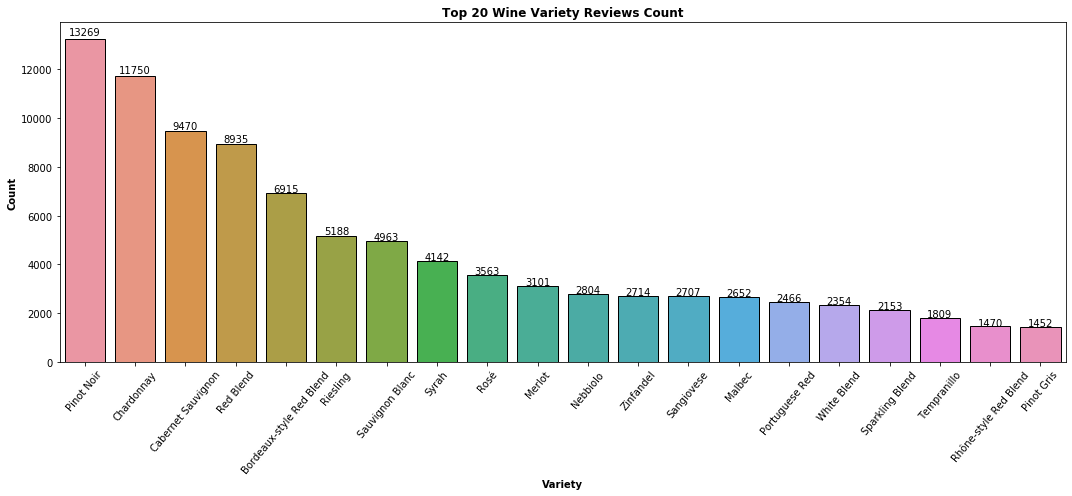

In [9]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['variety'], 
            order=df['variety'].value_counts().iloc[:20].index,
                     edgecolor='black')

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['variety'].value_counts()[i], ha="center")

plt.title('Top 20 Wine Variety Reviews Count', fontweight='bold')
plt.xlabel('Variety', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [10]:
# Calculate the percentage of n from the total population
n = 3
var_counts = df['variety'].value_counts().sum()
top_3 = df['variety'].value_counts().nlargest(n).sum()

percentage = round((top_3/var_counts*100), 2)

print('The top 3 varieties represent {}% of the population'.format(percentage))

The top 3 varieties represent 26.55% of the population


In [11]:
# Create a list with the 20 largest variety populations
variety_largest = df['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

# Create dataframe from that list
variety_index = df.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

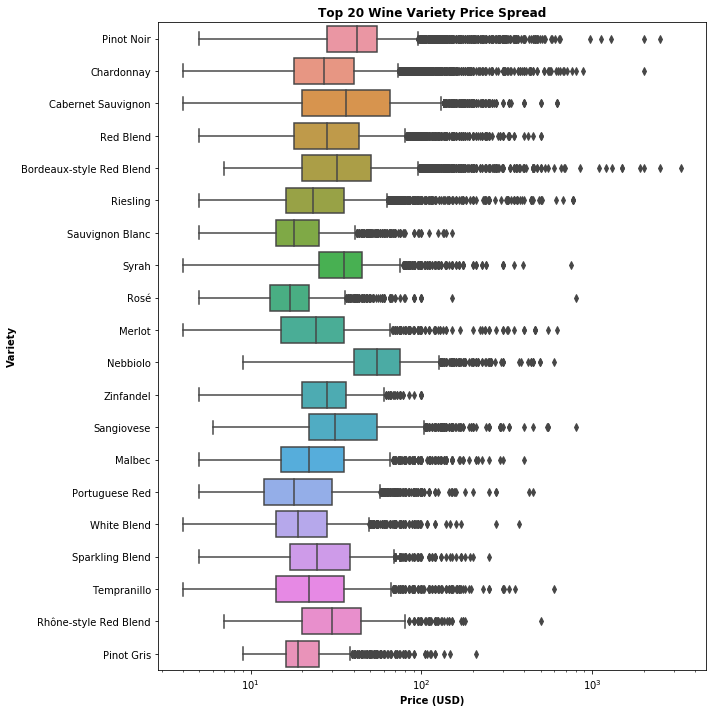

In [12]:
# Plot variety vs price
plt.figure(figsize=(10, 10))
graph = sns.boxplot(x=variety_index['price'], 
               y=variety_index['variety'])

# Log scale transform x axis
graph.figure.get_axes()[0].set_xscale('log')

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Price (USD)', fontweight='bold')


plt.tight_layout()
plt.show()

In [13]:
# The variety price statistics
variety_index.groupby('variety')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,6915.0,46.836656,83.334500,7.0,20.0,32.0,50.477273,3300.0
Cabernet Sauvignon,9470.0,47.834285,41.080732,4.0,20.0,36.0,65.000000,625.0
Chardonnay,11750.0,34.767884,41.502050,4.0,18.0,27.0,40.000000,2013.0
Malbec,2652.0,30.023756,26.587301,5.0,15.0,22.0,35.000000,400.0
Merlot,3101.0,29.576024,33.182678,4.0,15.0,24.0,35.000000,625.0
Nebbiolo,2804.0,62.138612,42.145085,9.0,40.0,55.0,75.000000,595.0
Pinot Gris,1452.0,23.469128,14.847091,9.0,16.0,19.0,25.000000,207.5
Pinot Noir,13269.0,47.555120,48.691025,5.0,28.0,42.0,55.000000,2500.0
Portuguese Red,2466.0,25.597014,25.070895,5.0,12.0,18.0,30.000000,450.0


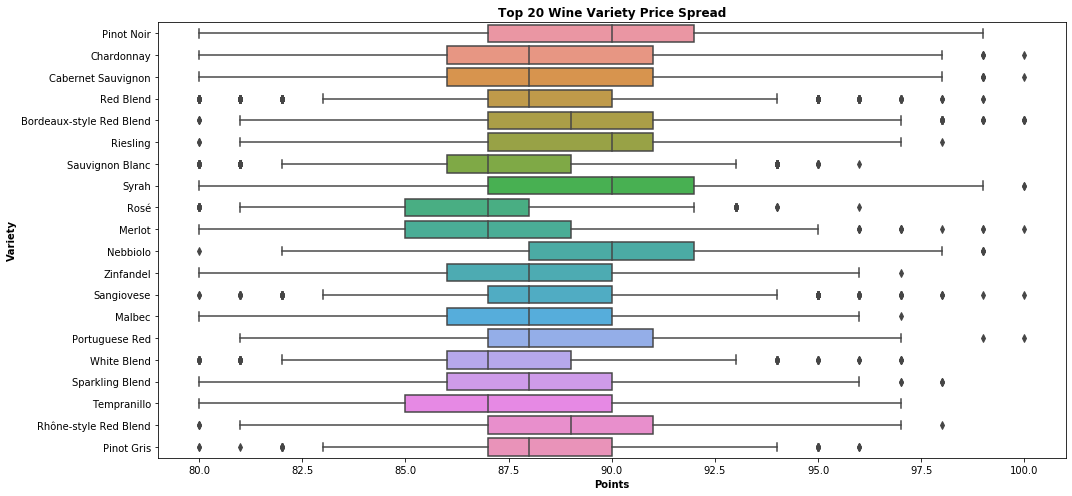

In [14]:
# plot the Variety vs Points Spread
plt.figure(figsize=(15, 7))
sns.boxplot(x=variety_index['points'], y=variety_index['variety'])

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

In [15]:
# Variety Points statistics
variety_index.groupby('variety')['points'].describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,6915.0,89.106435,3.136137,80.0,87.0,89.0,91.0,100.0
Cabernet Sauvignon,9470.0,88.607286,3.316585,80.0,86.0,88.0,91.0,100.0
Chardonnay,11750.0,88.340000,3.231957,80.0,86.0,88.0,91.0,100.0
Malbec,2652.0,87.983032,3.102440,80.0,86.0,88.0,90.0,97.0
Merlot,3101.0,87.207352,2.967114,80.0,85.0,87.0,89.0,100.0
Nebbiolo,2804.0,90.251070,2.717213,80.0,88.0,90.0,92.0,99.0
Pinot Gris,1452.0,88.499311,2.632171,80.0,87.0,88.0,90.0,96.0
Pinot Noir,13269.0,89.411636,3.124003,80.0,87.0,90.0,92.0,99.0
Portuguese Red,2466.0,88.810624,2.973620,81.0,87.0,88.0,91.0,100.0


### Countries and Regions
The US, France, and Italy produce 74% of the wine in this dataset. This is unsurprising due to the vast number of wineries in these countries. The US produces the most Pinot Noir, Chardonnay, and Cabernet Sauvignon. While France produces the most Bordeaux. Italy produces mainly Cabernet Sauvignons. 

What was interesting in the data is that the largest producers of wine did not have the highest average points per bottle of wine, which might have been expected due to their perceived expertise in producing wine. In contrast, as expected the largest producers of wine did not have the highest average price, this is likely based on the high volume of bottles being produced. As an illustration, France did have the largest deviation with many of its wines fetching the highest prices; however, due to the large volume of lower priced bottles also being produced, the average price per variety was lower. 

In [16]:
country = df['country'].unique()
prov = df['province'].unique()
region1 = df['region_1'].unique()
region2 = df['region_2'].unique()

print('Unique Provinces: {}\nUnique Region 1: {}'.format(len(prov), len(region1)),
     '\nUnique Region 2: {}\nUnique Countries: {}'.format(len(region2), len(country)))

Unique Provinces: 425
Unique Region 1: 1230 
Unique Region 2: 18
Unique Countries: 43


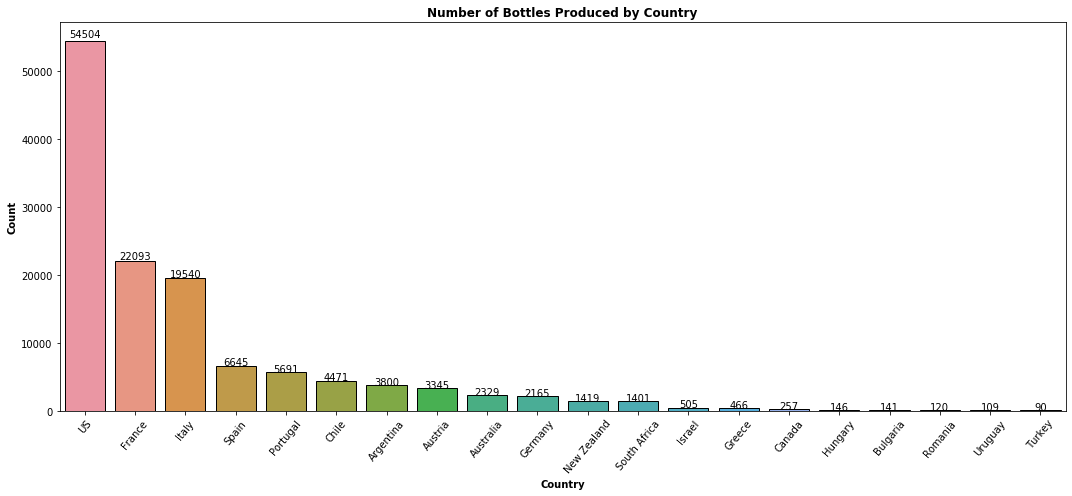

In [17]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['country'], 
                order=df['country'].value_counts().iloc[:20].index,
                     edgecolor='black')

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['country'].value_counts()[i], ha="center")

plt.title('Number of Bottles Produced by Country', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [18]:
# Calculate the percentage of n from the total population
n = 3
var_counts = df['country'].value_counts().sum()
top_3 = df['country'].value_counts().nlargest(n).sum()

percentage = round((top_3/var_counts*100), 2)

print('The top 3 countries represent {}% of the population'.format(percentage))

The top 3 countries represent 74.0% of the population


In [19]:
# Create a list of largest producers of wine
country_largest = df['country'].value_counts().nlargest(n).reset_index()
country_largest = country_largest['index']

# Create a new dataframe from that list
country_index = df.set_index('country')
country_index = country_index.loc[country_largest].reset_index()

# Get list of largest varieties from dataframe
variety_largest = country_index['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']


variety_index = country_index.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

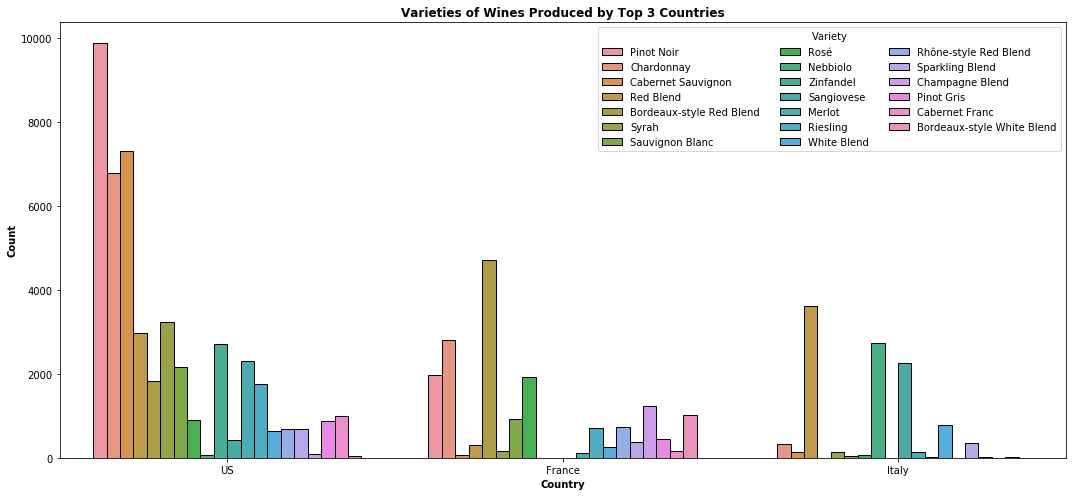

In [20]:
# Plot of the varieties produced by country

plt.figure(figsize=(15, 7))
sns.countplot(x=variety_index['country'], 
           hue=variety_index['variety'], edgecolor='black')

plt.title('Varieties of Wines Produced by Top 3 Countries', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

plt.tight_layout()
plt.show()

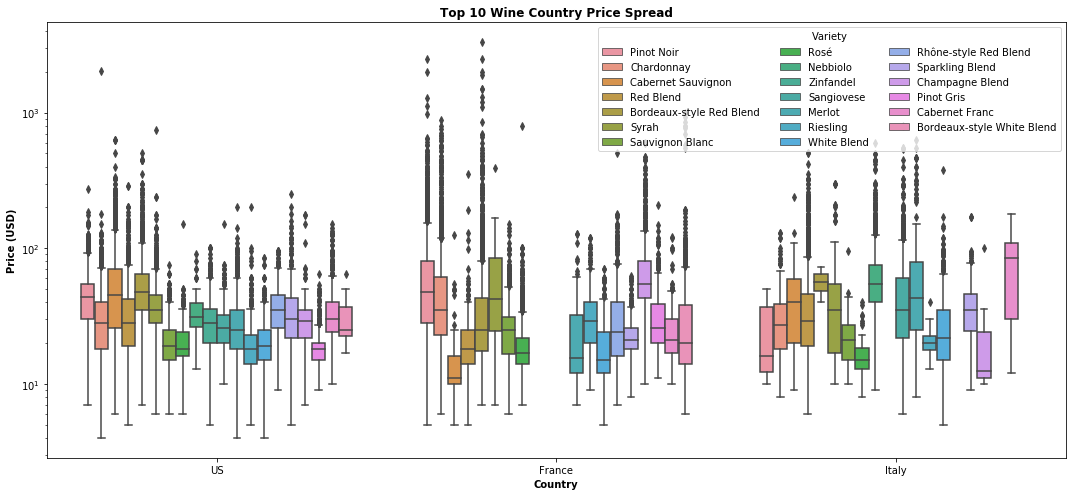

In [21]:
# Plot the Price per Country by Variety
plt.figure(figsize=(15, 7))
graph = sns.boxplot(x=variety_index['country'], y=variety_index['price'], 
                    hue=variety_index['variety'])

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.tight_layout()
plt.show()

In [22]:
# Average prices for 10 highest and lowest
country_avg = df.groupby('country')['price'].mean()
print('Higest Average Bottle Price per',country_avg.nlargest(10))
print('\nCheapest Average Bottle Price per',country_avg.nsmallest(10))

Higest Average Bottle Price per country
Switzerland    85.285714
England        51.168919
Germany        42.154503
France         41.028197
Hungary        40.626712
Italy          38.781537
US             36.550183
Canada         35.517510
Australia      35.310677
Austria        32.323468
Name: price, dtype: float64

Cheapest Average Bottle Price per country
Ukraine                    9.214286
Bosnia and Herzegovina    12.500000
India                     13.333333
Armenia                   14.500000
Bulgaria                  14.645390
Romania                   15.241667
Macedonia                 15.583333
Slovakia                  16.000000
Cyprus                    16.272727
Moldova                   16.745763
Name: price, dtype: float64


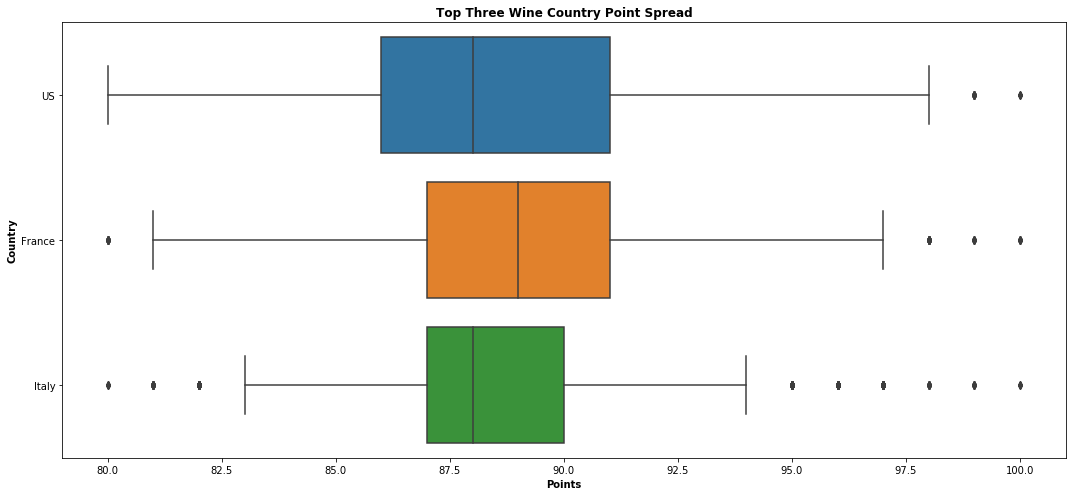

In [23]:
# Plot point Spread per Country by Variety
plt.figure(figsize=(15, 7))
sns.boxplot(x=country_index['points'], y=country_index['country'])

plt.title('Top Three Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

In [24]:
# Top 10 Countries with highest and lowest points
country_avg = df.groupby('country')['points'].mean()
print('Higest Average Bottle Points per',country_avg.nlargest(10))
print('\nLowest Average Bottle Points per',country_avg.nsmallest(10))

Higest Average Bottle Points per country
England       91.581081
India         90.222222
Austria       90.101345
Germany       89.851732
Canada        89.369650
Hungary       89.191781
China         89.000000
France        88.845109
Luxembourg    88.666667
Australia     88.580507
Name: points, dtype: float64

Lowest Average Bottle Points per country
Peru                      83.562500
Egypt                     84.000000
Ukraine                   84.071429
Brazil                    84.673077
Mexico                    85.257143
Romania                   86.400000
Chile                     86.493178
Bosnia and Herzegovina    86.500000
Argentina                 86.710263
Uruguay                   86.752294
Name: points, dtype: float64


### Points
The point distribution below shows an ideal gaussian distribution with the mean being 88.44 points. As pointed out in the variety sections, there is a correlation between price and points. The log scaled chart below shows the positive correlation between the two variables. The lowest point bottles on average sell for 16 USD while a perfectly rated bottle sells for 485 USD. Surprisingly, the highest priced bottle in the dataset (3300 USD) only scored 88 points. 

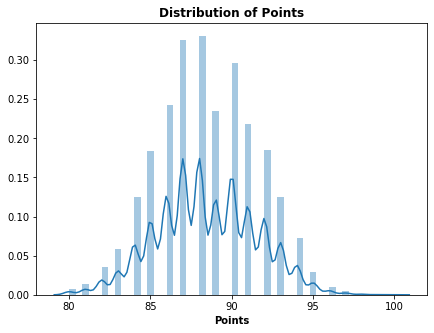

Average Points: 88.44705058233967

Median Point: 88.0


In [25]:
# Plot distribution plot of points
plt.figure(figsize=(7, 5))
sns.distplot(df['points'])

plt.title('Distribution of Points', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

plt.show()

avg_points = df['points'].mean()
med_points = df['points'].median()
print('Average Points: {}'.format(avg_points))
print('\nMedian Point: {}'.format(med_points))

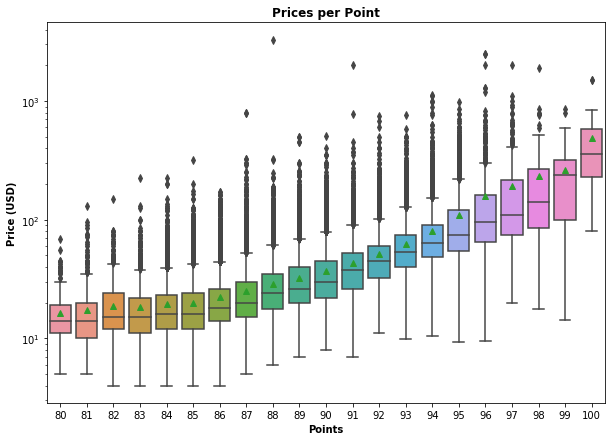

In [26]:
# Plot boxplot of price vs points
plt.figure(figsize=(10, 7))

graph = sns.boxplot(x=df['points'], y=df['price'], showmeans=True)

plt.title('Prices per Point', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.show() 

In [27]:
# Generate list of average price per point
score_price = df.groupby('points')['price'].mean()
print(score_price.sort_values(ascending=False))

points
100    485.947368
99     261.467424
98     233.577273
97     193.030223
96     158.067566
95     108.517725
94      80.785871
93      62.953385
92      51.044650
91      43.364174
90      36.965254
89      32.273501
88      28.745419
87      24.988004
86      22.202407
85      20.001526
84      19.364926
82      18.856131
83      18.209325
81      17.165462
80      16.346348
Name: price, dtype: float64


# Bottles
The first item explored in this section was, how many times on average a bottle was reviewed. Per the data below several bottles were reviewed multiple times, with the highest number of reviews being 11. A bottle on average was reviewed 1.09 times. Seven out of the ten most expensive bottles were Bordeaux style, all scoring in the high 90s point range. Each of the most expensive bottles were produced in France, except one which was produced in the US. The most expensive Pinot Noir varieties were produced by the same winery, with the more expensive vintage produced in 2010 and the second most expensive vintage produced in 2005. 

In [28]:
# Generate list of 10 most reviewed bottles and the counts
print('Highest Number of Reviews per Vintage')
df['title'].value_counts().nlargest(10)

Highest Number of Reviews per Vintage


Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                11
Korbel NV Brut Sparkling (California)                                  9
Segura Viudas NV Extra Dry Sparkling (Cava)                            8
Ruinart NV Brut Rosé  (Champagne)                                      7
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                7
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                   7
Mumm Napa NV Brut Prestige Sparkling (Napa Valley)                     6
Jacquart NV Brut Mosaïque  (Champagne)                                 6
J Vineyards & Winery NV Brut Rosé Sparkling (Russian River Valley)     6
Pierre Sparr NV Brut Réserve Sparkling (Crémant d'Alsace)              6
Name: title, dtype: int64

In [29]:
# Calculate the average reviews per bottle
avg_bottle = df['title'].value_counts().mean()

print('Average Number Reviews per Bottle: {}'.format(
    round(avg_bottle, 2)))

Average Number Reviews per Bottle: 1.09


In [30]:
# Sort dataframe by highest price
top_bottles = df.sort_values(by='price', ascending=False)

# Print 10 highest priced bottles
top_bottles[['title', 'variety', 'winery', 'price', 'points', 'country']].head(10)

,title,variety,winery,price,points,country
80253,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,3300.0,88,France
15832,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2500.0,96,France
98332,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2500.0,96,France
120333,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair,2013.0,91,US
65320,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2000.0,97,France
113510,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2000.0,96,France
1557,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux,1900.0,98,France
111702,Château Cheval Blanc 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Cheval Blanc,1500.0,100,France
111700,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild,1500.0,100,France
1574,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,1300.0,96,France


## Wineries
The wineries that produced the most varieties of wines are located in Portugal, US, France, and Chile. Here are some highlights identified in the charts below:
    1. Louis Latour produces only Chardonnay and Pinot Noir, which commands the highest price out of all the wineries below. While their wines had higher than average points, there were many wineries that scored better such as Williams Selyem.
    2. DFJ Vinhos from Portugal had the lowest price of all the wineries, and their bottles earned lower than average points. The data shows a correlation between the diversification of variety and price i.e. the more varieties a winery produces, the lower the quality and the cheaper the selling price.
    3. The charts below show a strong correlation between price and variety of wine. Pinot Nior and Chardonnay bottles were the highest priced varieties for most wineries. 

In [31]:
winery = df['winery'].unique()
print('Unique Wineries: {}'.format(len(winery)))

Unique Wineries: 16745


In [32]:
# Create list of 10 largest wineries
winery_largest = df['winery'].value_counts().nlargest(10).reset_index()
winery_largest = winery_largest['index']

# Create dataframe of 10 largest winereies
winery_index = df.set_index('winery')
winery_index = winery_index.loc[winery_largest].reset_index()

# Get list of largest varieties from dataframe
variety_largest = winery_index['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']


variety_index = winery_index.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

In [33]:
# Count of the number of wineries 
print('Countries with the highest number of wineries: {}'.format(
      winery_index['country'].unique()))

Countries with the highest number of wineries: ['Portugal' 'US' 'France' 'Chile']


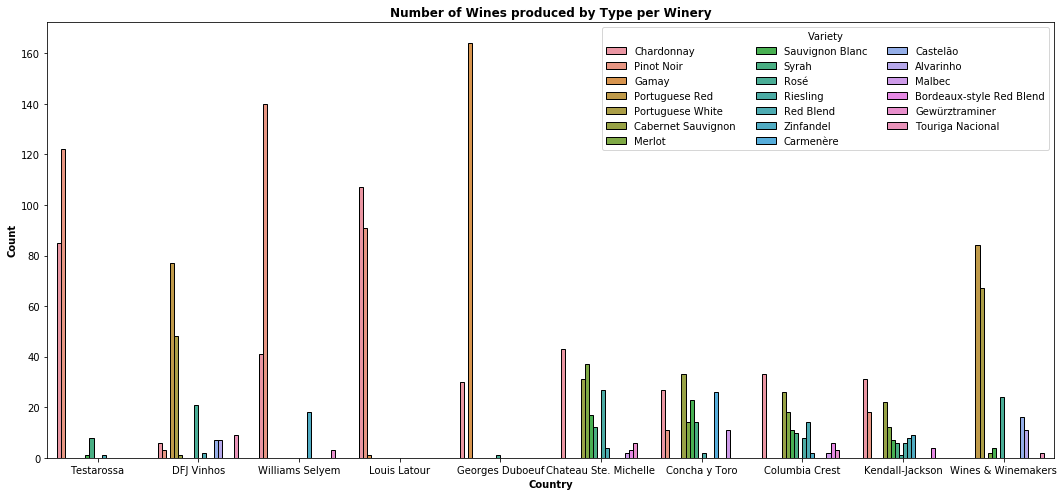

In [34]:
# Plot of the varieties produced by country

plt.figure(figsize=(15, 7))
sns.countplot(x=variety_index['winery'], 
           hue=variety_index['variety'], edgecolor='black')

plt.title('Number of Wines produced by Type per Winery', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

plt.tight_layout()
plt.show()

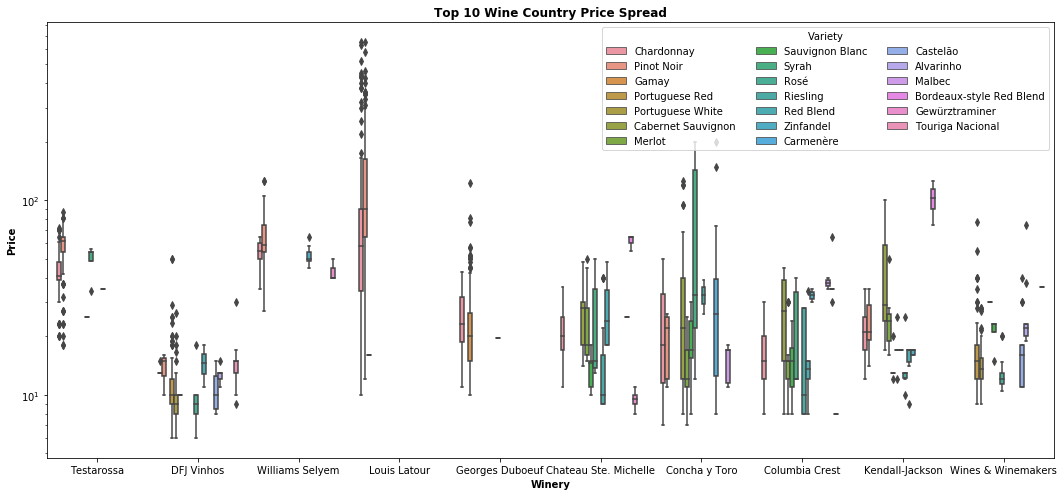

In [35]:
plt.figure(figsize=(15, 7))
graph = sns.boxplot(x=variety_index['winery'], y=variety_index['price'],
                   hue=variety_index['variety'])

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xlabel('Winery', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.legend(title='Variety', ncol=3, loc='upper right')
plt.tight_layout()
plt.show()

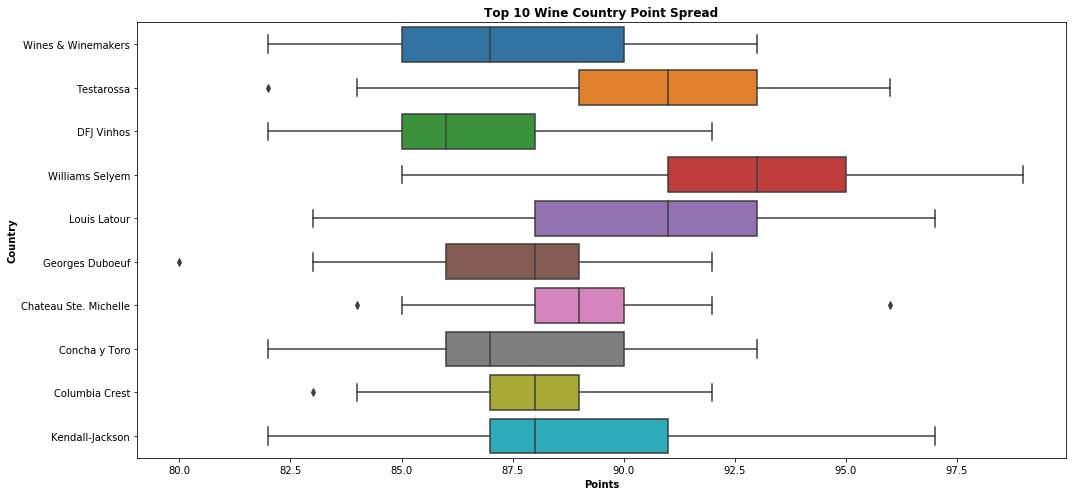

In [36]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=winery_index['points'], y=winery_index['winery'])

plt.title('Top 10 Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

## Tasters
The tasters of the wine in this dataset are identified below. The tasters with the most tasting notes are Roger Voss, Michael Schachner, and Kerin O'Keefe. The tasters with the highest number of reviews had similar point averages to the data average. 

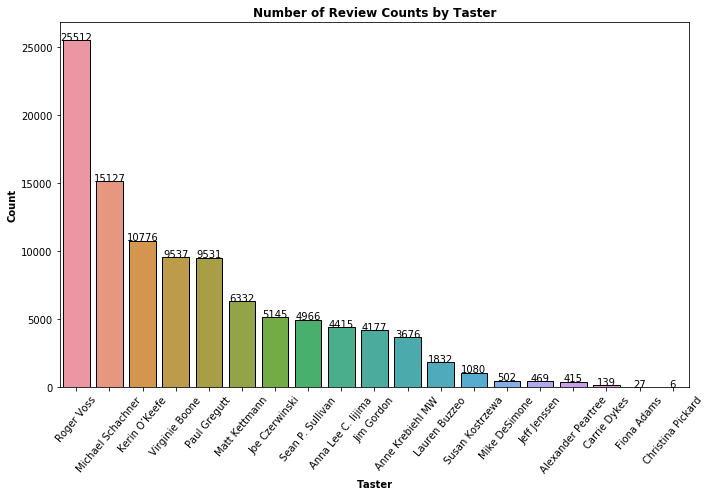

In [37]:
plt.figure(figsize=(10, 7))

# Plot the chart of Tasters
graph = sns.countplot(x=df['taster_name'], 
                      order=df['taster_name'].value_counts().index,
                     edgecolor='black')

# Add count total for each bar
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['taster_name'].value_counts()[i],ha="center")
    i += 1

plt.title('Number of Review Counts by Taster', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [38]:
# Create a list with the 20 largest variety opulations
variety_largest = df['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

# Create dataframe from that list
variety_index = df.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

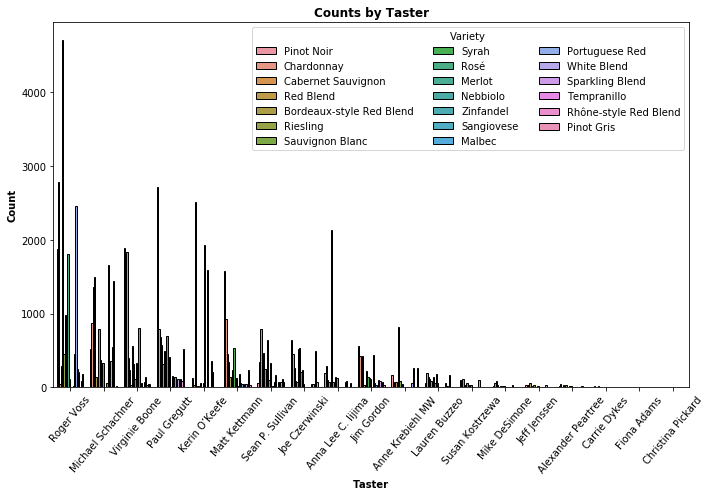

In [39]:
plt.figure(figsize=(10, 7))

# Plot the chart of Tasters and variety counts
graph = sns.countplot(x=variety_index['taster_name'], 
                      order=variety_index['taster_name'].value_counts().index,
                     edgecolor='black', hue=variety_index['variety'])

plt.title('Counts by Taster', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.legend(title='Variety', ncol=3, loc='upper right')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [40]:
# Print points statistics and average points per taster
print(df['points'].describe())
print('\n', df.groupby('taster_name')['points'].mean())

count    129907.000000
mean         88.447051
std           3.040078
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

 taster_name
Alexander Peartree    85.855422
Anna Lee C. Iijima    88.415629
Anne Krebiehl MW      90.562568
Carrie Dykes          86.395683
Christina Pickard     87.833333
Fiona Adams           86.888889
Jeff Jenssen          88.328358
Jim Gordon            88.626287
Joe Czerwinski        88.537221
Kerin O’Keefe         88.867947
Lauren Buzzeo         87.735262
Matt Kettmann         90.008686
Michael Schachner     86.906921
Mike DeSimone         89.097610
Paul Gregutt          89.082573
Roger Voss            88.708490
Sean P. Sullivan      88.755739
Susan Kostrzewa       86.598148
Virginie Boone        89.213379
Name: points, dtype: float64


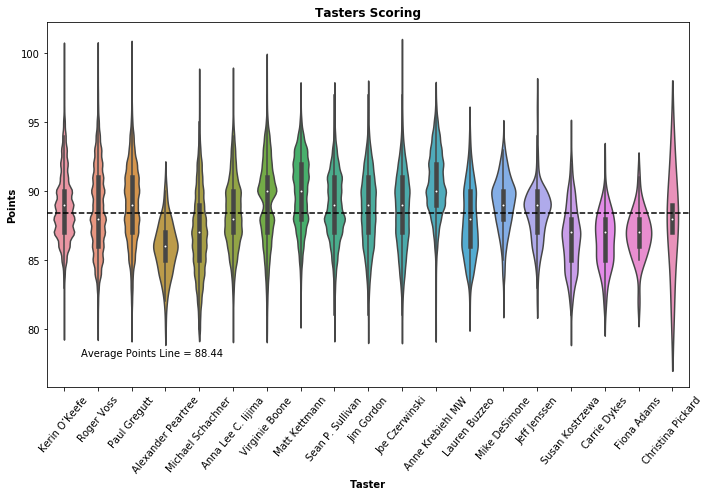

In [41]:
# Plot violin plot of tasters scoring
plt.figure(figsize=(10, 7))

sns.violinplot(x=df['taster_name'], y=df['points'])

# Plot points average line
plt.axhline(df['points'].mean(), color='black', ls='--')
plt.text(0.5,78, 'Average Points Line = 88.44')

plt.title('Tasters Scoring', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Points', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

## Year
From the year data exploration below several key items were learned:
    1. The majority of the bottles were produced in the last 15 years with the mean being 2010.
    2. There is a positive correlation between price and the year of the bottle. The older the bottle the higher average price it commands.
    3. There is no correlation between the age of the bottle and the points assigned to the bottle. 

In [42]:
# Create dataframe column of bottle year based on the title of bottle
df['year'] = df['title'].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

# Keep only first 4 digits of numeric numbers
years = []
for year in df['year']:
    year = ''.join(year[:4])
    years.append(year)

# Convert string to numeric    
df['year'] = years
df['year'] = pd.to_numeric(df['year'], errors='coerce', downcast='integer')

# Set values outside date range to None
mask = df['year'] > 2017
column_name = 'year'
df.loc[mask, column_name] = None

mask = df['year'] < 1990
df.loc[mask, column_name] = None

# Print year stats
df['year'].describe()

count    124342.000000
mean       2010.693716
std           3.547258
min        1990.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64

In [43]:
# Sum of NA values
df['year'].isna().sum()

5565

In [44]:
# Fill based on average year
df['year'] = df['year'].fillna(df['year'].mean())
df['year'] = round(df['year'])
df['year'].isna().sum()

0

In [45]:
# Convert year column from float to integer
df['year'] = df['year'].astype(int)

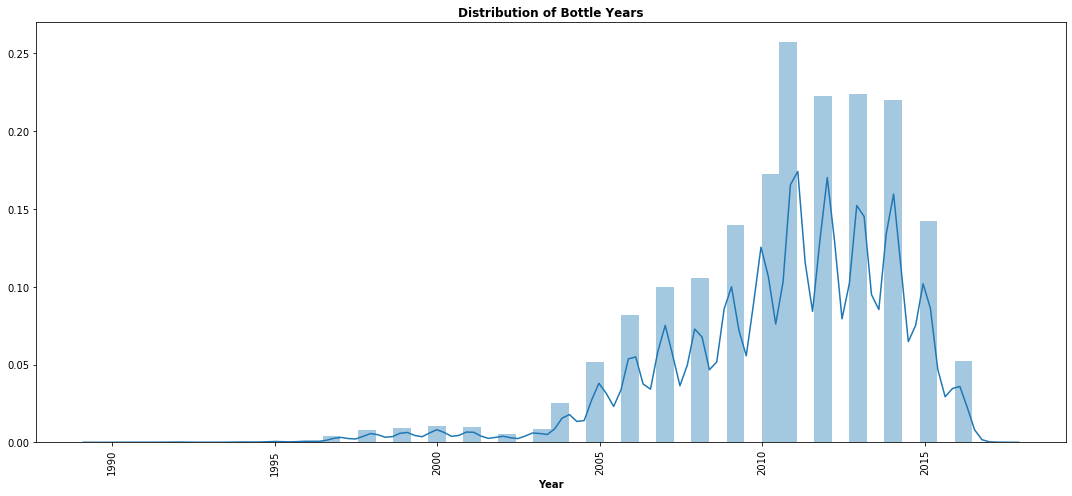

In [46]:
# Plot distribution of bottle years
plt.figure(figsize=(15, 7))

graph = sns.distplot(df['year'])

plt.xlabel('Year', fontweight='bold')
plt.title('Distribution of Bottle Years', fontweight='bold')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

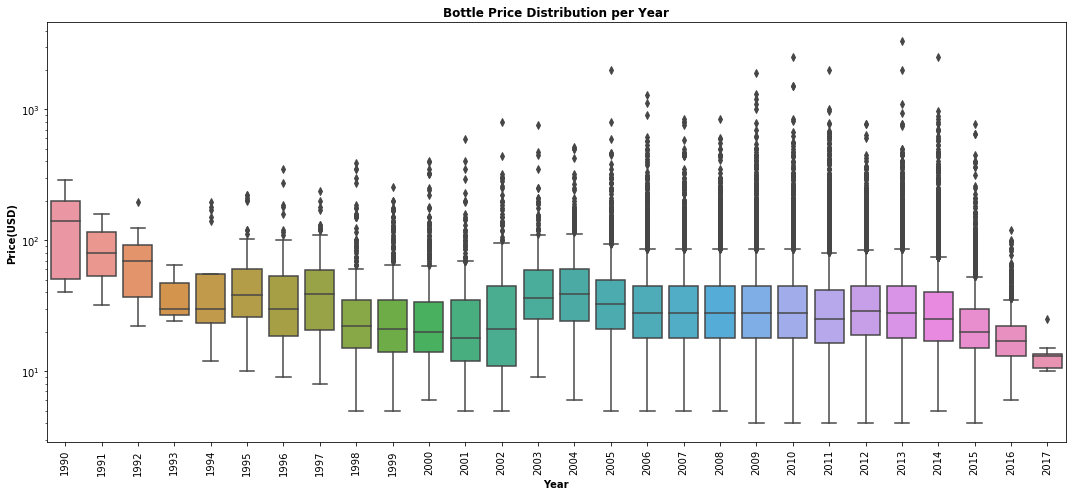

In [47]:
# Plot years vs price
plt.figure(figsize=(15, 7))

graph = sns.boxplot(x=df['year'], y=df['price'])
plt.xticks(rotation=90)

plt.ylabel('Price(USD)', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.title('Bottle Price Distribution per Year', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.tight_layout()
plt.show()

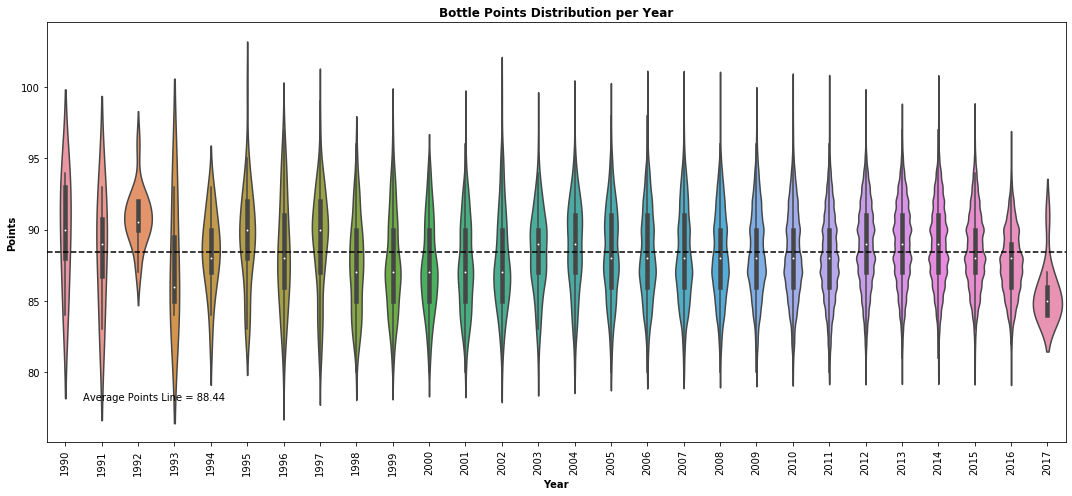

In [48]:
# Plot points per Year
plt.figure(figsize=(15, 7))

sns.violinplot(x=df['year'], y=df['points'])
plt.xticks(rotation=90)

plt.ylabel('Points', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.title('Bottle Points Distribution per Year', fontweight='bold')

# Plot points average line
plt.axhline(df['points'].mean(), color='black', ls='--')
plt.text(0.5,78, 'Average Points Line = 88.44')

plt.tight_layout()
plt.show()

## Correlations
The correlation heatmap below proves key assumptions made above. One, there is a positive correlation between the price of a vintage and the points of the vintage. It also shows that there is no correlation between the  year of the vintage and the points assigned. The correlation heatmap below confirmed there is a negative correlation between the price of a vintage and the year. The younger the age of a vintage the cheaper the price. 

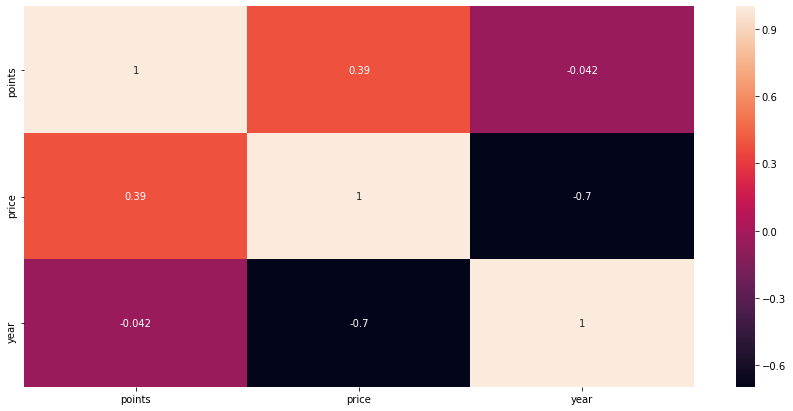

In [49]:
from sklearn.preprocessing import normalize

# Normalize the price points and year columns
norm = ['price', 'points', 'year']

df_corr = df
df_corr[norm] = normalize(df_corr[norm])

# Create correlation variable
df_corr = df_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(df_corr, annot=True)
plt.show()

## Description
This section is where things start getting fun. As seen in the word cloud below there are many keywords that could be associated with certain varities of wines. The wine description will be cleaned, and the key words will be extracted below using Count Vectorizer and various functions. See below for details:

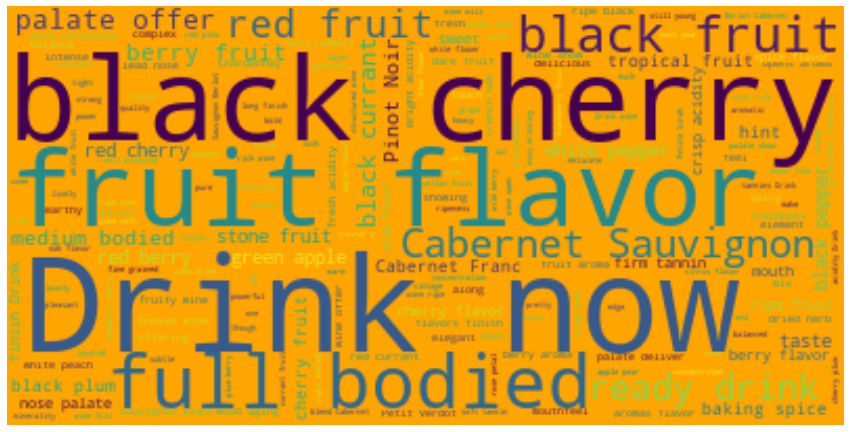

In [50]:
from wordcloud import WordCloud

# Create wordcloud of most used words in description
wordcloud = WordCloud(background_color='orange').generate(
            ''.join(df['description']))

plt.figure(figsize=(15, 10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [51]:
# Get the word count stats per description
word_count = df['description'].apply(lambda x: len(str(x).split(' ')))
word_count.describe()

count    129907.000000
mean         40.382712
std          11.112606
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: description, dtype: float64

In [52]:
pd.Series(''.join(df['description']
                 ).split()).value_counts().nlargest(25)


and        346745
of         172678
the        168077
a          157383
with       115529
is          96179
this        72436
in          59632
wine        55946
to          55242
The         45426
on          42771
flavors     39304
that        35404
aromas      31044
it          30867
from        29910
fruit       29782
but         29349
palate      26171
are         25759
has         24498
black       24252
It          23228
for         20597
dtype: int64

#### Description Cleaning
Most of the top words in the descriptions are common stop words such as and, of, the, etc. Furthermore, the words wine, flavor, and fruit are also very common. These words will be removed from the description. Additionally, the function below will remove all puncuation, tags, special characters, digits, and convert to the strings to lowercase and base word. 

In [53]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Create a list of stop words
stop_words = set(stopwords.words('english'))
stop_words = ['wine', 'flavor', 'fruit'] + list(stop_words)

In [54]:
def clean_text(words):
    """ Clean up all text
    
    Parameters:
        words(str): The text the needs to be cleaned 
    Return: Cleaned text
    """

    cleaned_list = []
    
    for i in range(0, word_count.count()):
        #Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', words[i])
    
        #Convert to lowercase
        text = text.lower()
    
        #remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)
    
        # Convert to list from string
        text = text.split()
    
        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        cleaned_list.append(text)
    
    return cleaned_list

df['description'] = clean_text(df['description'])

# Print first 5 descriptions
df['description'].head()

0    aroma include tropical broom brimstone dried h...
1    ripe fruity smooth still structured firm tanni...
2    tart snappy flavor lime flesh rind dominate gr...
3    pineapple rind lemon pith orange blossom start...
4    much like regular bottling come across rather ...
Name: description, dtype: object

#### Count Vectorizer
A count vectorizer will be used to extract the the most meaningful words in each description. The stop words will be removed and the the highest 20% of the meaningful words will be ignored. The top words are graphed below in the countplots. All the top 100 words identified below will be used to create a dummies list of values for the dataframe. These additional features will hopefully help differentiate the different varieties in the modeling phase. 

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# Create 100 feature cv of bottom 80%, and three word range
cv = CountVectorizer(max_df=.80, stop_words=stop_words,
                    max_features=100, ngram_range=(1, 3))

# Create list of descriptions
corpus = df['description'].tolist()

X = cv.fit_transform(corpus)

# Preview list of words
list(cv.vocabulary_.keys())[:10]

['aroma',
 'dried',
 'herb',
 'palate',
 'apple',
 'citrus',
 'acidity',
 'ripe',
 'fruity',
 'smooth']

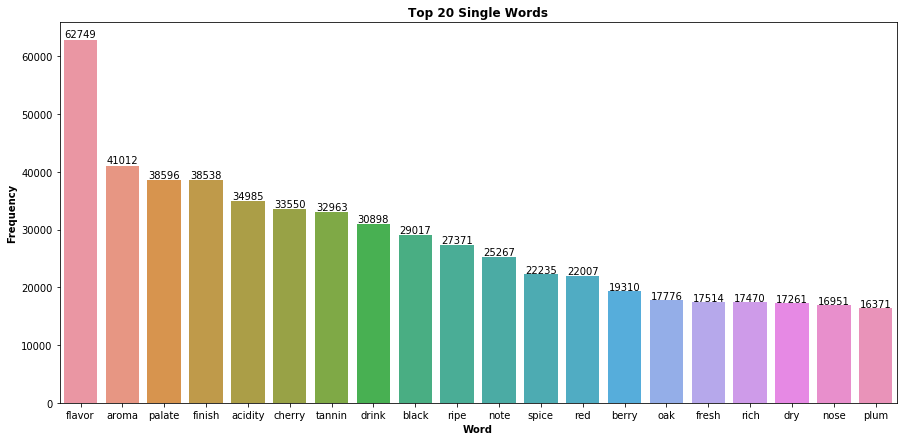

In [56]:
def get_top_n_words(corpus, n, y):
    """Return the the most frequent one word in corpus
    
    Parameters:
        corpus(str): List of words
        n(int): Number or integers to return
        y(int): Ngram range"""
    
    vec = CountVectorizer(ngram_range=(y,y),  
            max_features=200).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20, y=1)
top_df = pd.DataFrame(top_words)
top_df.columns=['Word', 'Freq']

# Plot barplot of most freq words
plt.figure(figsize=(15, 7))
graph = sns.barplot(x='Word', y='Freq', data=top_df)

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        top_df['Freq'][i], ha="center")

plt.title('Top 20 Single Words', fontweight='bold')
plt.xlabel('Word', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')   
    
plt.show()

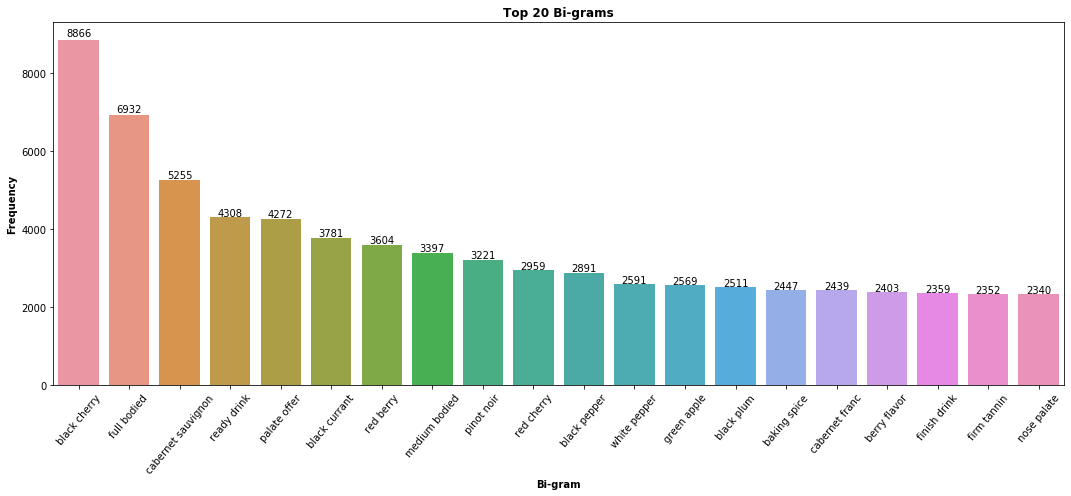

In [57]:
# Convert most freq words to dataframe for plotting bar plot
top2_words = get_top_n_words(corpus, n=20, y=2)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=['Bi-gram', 'Freq']

# Plot barplot of 2 most freq words
plt.figure(figsize=(15, 7))
graph = sns.barplot(x='Bi-gram', y='Freq', data=top2_df)

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        top2_df['Freq'][i], ha="center")

plt.title('Top 20 Bi-grams', fontweight='bold')
plt.xlabel('Bi-gram', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')       
    
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

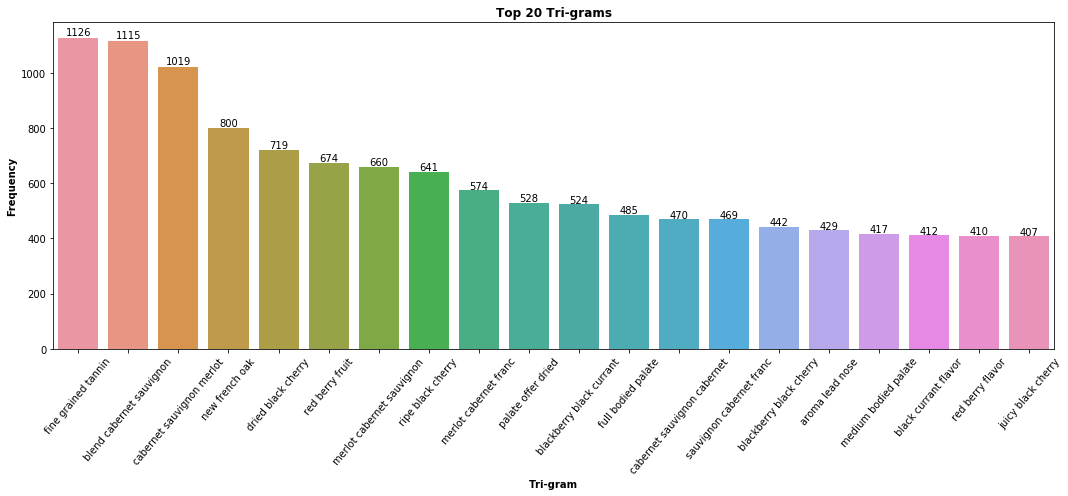

In [58]:
# Convert most freq words to dataframe for plotting bar plot
top3_words = get_top_n_words(corpus, n=20, y=3)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=['Tri-gram', 'Freq']


# Plot barplot of 3 most freq words
plt.figure(figsize=(15, 7))
graph = sns.barplot(x='Tri-gram', y='Freq', data=top3_df)

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        top3_df['Freq'][i], ha="center")

plt.title('Top 20 Tri-grams', fontweight='bold')
plt.xlabel('Tri-gram', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')       
    
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

The term-frequency times inverse document-frequency(tf-idf) is used to weight the words in the description. The purpose of the tf-idf is that it scales down the impact of the highly frequent words in the description, which would be a less impactful feature than the smaller words. 

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer

# Weight the words in the descriptions
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# Get feature names
feature_names=cv.get_feature_names()
 
# Fetch document for which keywords needs to be extracted
doc=corpus[1]
 
# Generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [60]:
# Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    """ Sort tf_idf in descending order
    Parameter:
    coo_matrix: coordinate matrix
    Returns: coo matrix in descending order"""
    
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn):
    """get the feature names and tf-idf score of top n items
    Parameters: 
    feature_names(string): Feature names from count vectorizer
    sorted_items(list): Sorted td-idf vectors in descending order 
    topn(int): Number of weighted words to return
    Returns: Dictionary of topn words and weighted value
    """
    
    # Use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # Word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    # Create a tuples of feature, score
    # Results = zip(feature_vals, score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

# Sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

# Extract only the top n
keywords=extract_topn_from_vector(feature_names, sorted_items, 5)
 
# Print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
ripe fruity smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better

Keywords:
still 0.399
smooth 0.376
firm 0.354
fruity 0.35
juicy 0.348


The abstract above is a print out of the cleaned up description for a vintage of wine. The keywords printed above are the top 5 highest weighted words in that description. These keywords are appended to the keyword list to create dummies with. 

In [61]:
def keyword_gen(description):
    """Returns a list of keywords
    Parameters:
    description(array): Corpus of all descriptions to extract keywords"""
    
    keyword_list = {}
    
    # Fetch document for which keywords needs to be extracted
    for words in description:
        doc = words
 
        # Generate tf-idf for the given document
        tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
         
        # Sort the tf-idf vectors by descending order of scores
        sorted_items = sort_coo(tf_idf_vector.tocoo())
        
        # Extract only the top n
        keywords = extract_topn_from_vector(feature_names, sorted_items, 5)
        keyword_list.update(keywords)
    
    # Convert dictionary to list based on keys
    keyword_list = list(keyword_list.keys())
    temp_list = []
    
    # Append unique words to temp_list
    for word in keyword_list:
        if word not in temp_list:
            temp_list.append(word)
    
    # Get list of column names and remove all keywords with similar column name
    column_names = list(df.columns)
    temp_list = [x for x in temp_list if x not in column_names]
    
    # Print number of keywords
    print('There are {} keywords.'.format(len(temp_list)))
    return temp_list

In [62]:
import time
start_time = time.time()

# Generate keyword list
keywords = keyword_gen(corpus)

print("\n--- %s seconds ---" % (time.time() - start_time))  

There are 99 keywords.

--- 66.53134202957153 seconds ---


In [63]:
def keyword_dummies(reviews):
    """Return dummies for each keyword
    Parameters:
    reviews(array): descriptions of all wine tasting notes"""
    
    # Iterate through each word in reviews a for keywords
    for key in keywords:
        df[str(key)] = reviews.str.contains(
            str(key), case=False)
    
    # Assign 1 for True, 0 for False
    df.iloc[:, 13:] *= 1

In [64]:
# Generate all the keyword dummies
keyword_dummies(df['description'])
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,...,bodied,cherry,full,finish,well,taste,rich,make,also,age
0,Italy,aroma include tropical broom brimstone dried h...,Vulkà Bianco,0.043178,0.007444,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,0,0,0,0,0,0,0,1
1,Portugal,ripe fruity smooth still structured firm tanni...,Avidagos,0.043220,0.007452,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,0,0,0,0,0,0
2,US,tart snappy flavor lime flesh rind dominate gr...,NaN,0.043178,0.006948,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,0,0,0,0,0,0,0
3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,0.043178,0.006452,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,1,0,0,0,0,0,0
4,US,much like regular bottling come across rather ...,Vintner's Reserve Wild Child Block,0.043178,0.032259,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,0,0,0,0,0,0,0


# Model
The aim of the models below is to predict the variety of the wine. This will be done with the following features:
    1. Price
    2. Points
    3. Year
    4. Description Keyword Dummies
    5. Country and Province Dummies

Classifer models used to predict the variety of wines are K Nearest Neighbors(KNN), Naive Bayes, and Random forest. 'Sector Vector Classifer' and 'Gradient Boosting' models were not implemented due to the memory and time constraints. Use of PCA was explored below as a possible fix of these constraints. Unfortunately, there were eigen values above 1 to create PCA compenents with. 

# Model 1: KNN
The KNN model uses the 10 nearest data points for each point to estimate the correct variety classification. The distance of each feature to the point is weighted when making this classification. The accuracy results of the training dataset was very impressive with 99% of the variables being classified correctly. The only problem with this model was that it was severely overfitted with the testing dataset only being 52% accurate.

In [65]:
# Get dummies for country and province
objects = ['country', 'province']
df_model = pd.concat([df, pd.get_dummies(df[objects], drop_first=True)], axis=1)

# Normalize the price points and year columns
norm = ['price', 'points', 'year']

df_model[norm] = normalize(df_model[norm])
df_model.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,...,province_Wellington,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa
0,Italy,aroma include tropical broom brimstone dried h...,Vulkà Bianco,0.043178,0.007444,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,0,0,0,0,0,0,0,0
1,Portugal,ripe fruity smooth still structured firm tanni...,Avidagos,0.043220,0.007452,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,0,0,0,0,0,0
2,US,tart snappy flavor lime flesh rind dominate gr...,NaN,0.043178,0.006948,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,0,0,0,0,0,0,0
3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,0.043178,0.006452,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,0,0,0,0,0,0,0
4,US,much like regular bottling come across rather ...,Vintner's Reserve Wild Child Block,0.043178,0.032259,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Y is the target variable
Y = df_model['variety']

# X is the features
X = df_model.select_dtypes(exclude='object')

In [67]:
from sklearn.decomposition import PCA

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

# Return number of components above 1
components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=components)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

Number of Components: 0
The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.0


In [68]:
# Y is the target variable
Y = df['variety']
Y = Y.sample(frac=.3, random_state=1)

# X is the features
X = df_model.select_dtypes(exclude ='object')
X = X.sample(frac=.3, random_state=1)

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
start_time = time.time()

# Create trainging and test sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

neighbors = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Fit the training data
neighbors = neighbors.fit(X_train, Y_train)

pred_train = neighbors.predict(X_train)
pred_test = neighbors.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(neighbors, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(neighbors, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Cross Validation of Training Set:
[0.48922082 0.50428844 0.51377921 0.52465709 0.52806207]

Cross Validation of Test Set:
[0.4321985  0.44145272 0.47254902 0.4794889  0.48687845]

Accuracy Score of Training Set: 0.9999679250729705

Accuracy Score of Test Set: 0.518024374599102

--- 2137.6757736206055 seconds ---


# Model 2: Naive Bayes
A Naive Bayes classifer model is effective in several ways. It is a simple model that has great performance; only 9 seconds to run vs the KNN at 35 minutes. It will also provides a solid baseline for the accuracy score of the dataset, which in the variety model is roughly 54%. This indicates several potential issues. One, there are a lot of varieties of wine that only have one bottle associated. If the naive bayes model has not seen that category in the training set, it will assign it a zero. Meaning there will be a lot of wines that are incorrectly categorized as seen below. Second, naive bayes assumes that the values are not correlated with one another. In the data exploration, price and points were slightly correlated with one another at .39. This lack of independence skews the model slightly. Even though this model did not give impressive accuracy scores, it did have strong performance in terms of run times and no overfitment. 

In [70]:
start_time = time.time()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# Fit train and test data
bnb = bnb.fit(X_train, Y_train)

pred_train = bnb.predict(X_train)
pred_test = bnb.predict(X_test)

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(bnb, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(bnb, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))   

Cross Validation of Training Set:
[0.51863258 0.5271601  0.53730862 0.55143697 0.54853087]

Cross Validation of Test Set:
[0.44085401 0.45272386 0.51045752 0.49764627 0.50621547]

Accuracy Score of Training Set: 0.5534528658947301

Accuracy Score of Test Set: 0.5320076972418217

--- 9.248128414154053 seconds ---


# Model 3: Random Forest
The random forest is one of the best supervised learning models. It is an ensemble learning method that makes a prediction using multiple decision trees, which leads to high accuracy and performance. There are several issues with the model below, though. For starters, random forests are extremely prone to overfitting. This is evident with the training set below having an accuracy of 99% and the test set having 55% accuracy. Another issue is that the random forest is a black box where one has a hard time gaining an understanding of the full decision. One way to gain insight into the random forest is to plot the feature importance, as shown below. In the case of the variety model the top three most important features are:
    1. Year
    2. Price
    3. Points

Even though these features had the highest importance, it was only slighty above .04. Luckily, the model can be tuned to increase the accuracy performance. 

In [71]:
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

# Fit train and test data
forest = forest.fit(X_train, Y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(forest, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(forest, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Cross Validation of Training Set:
[0.52386819 0.53986658 0.55100725 0.53788374 0.55331793]

Cross Validation of Test Set:
[0.44373918 0.44145272 0.48300654 0.49092132 0.50690608]

Accuracy Score of Training Set: 0.9934567148859736

Accuracy Score of Test Set: 0.5448364336112893

--- 28.083125114440918 seconds ---


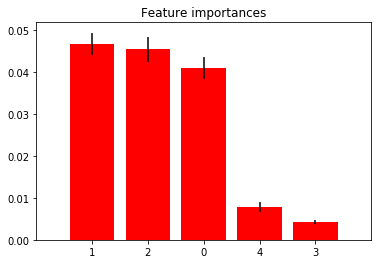

In [72]:
# Plot the feature importances
importances = forest.feature_importances_[:5]
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(range(5), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(5), indices)
plt.xlim([-1, 5])
plt.show()

In [73]:
importances = forest.feature_importances_[:5]
indices = np.argsort(importances)[::-1]
print(sorted(importances, reverse=True))

[0.046780389093215025, 0.04545738380625546, 0.0410662648617927, 0.007796018856890461, 0.004243045858535271]


In [74]:
X_train.head()

,points,price,year,dried,herb,citrus,apple,acidity,still,smooth,...,province_Wellington,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa
27249,0.045757,0.022381,0.998702,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
53316,0.043238,0.014910,0.998954,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
66530,0.041753,0.007456,0.999100,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,0.043263,0.008702,0.999026,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
125659,0.045176,0.017375,0.998828,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Improving the Model
The Niave Bayes model showed that the baseline accuracy of the models are around 54%. The model that will be improved is the random forest, due to the best accuracy for the training set, speed, and the overall ease of tuning. Several ideas come to mind for improving the random forest model. In the data exploration of the varieties, it is noted that there are 701 varieties, with 335 varieties having 5 or fewer samples. This is a huge distinction from the top 20 varieties, which each have over 1,000 bottles. The data can be reduced to having only the top 20 varieties. Additionally, the minority varieties can be oversampled so there is an equal distirbution between all the varieties. Lastly, the random forest can be improved further by the use of hyper parameters. 

## Model 4: Top 20 Varieties
A dataset with the top 20 varieties was created. This dataset performed better than the original random forest with 70% accuracy in the test set. While the model is still overfitted, there has been some progress in overfitment reduction. This dataset with the top 20 varieties will be further improved upon in the models below.

In [75]:
# Create a list with the 20 largest variety opulations
variety_largest = df_model['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

# Create dataframe from that list
var_df = df_model.set_index('variety')
var_df = var_df.loc[variety_largest].reset_index()

var_df.head()

,variety,country,description,designation,points,price,province,region_1,region_2,taster_name,...,province_Wellington,province_Western Australia,province_Western Cape,province_Wiener Gemischter Satz,province_Württemberg,province_Zenata,province_Österreichischer Perlwein,province_Österreichischer Sekt,province_Štajerska,province_Župa
0,Pinot Noir,US,much like regular bottling come across rather ...,Vintner's Reserve Wild Child Block,0.043178,0.032259,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0
1,Pinot Noir,US,sleek mix tart berry stem herb along hint oak ...,NaN,0.043177,0.009926,Oregon,Oregon,Oregon Other,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0
2,Pinot Noir,US,oak earth intermingle around robust aroma wet ...,King Ridge Vineyard,0.043196,0.034259,California,Sonoma Coast,Sonoma,Virginie Boone,...,0,0,0,0,0,0,0,0,0,0
3,Pinot Noir,US,many erath vineyard designates strongly herbal...,Hyland,0.042734,0.024845,Oregon,McMinnville,Willamette Valley,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0
4,Pinot Noir,US,stiff tannic slowly open brings brambly berry ...,NaN,0.042766,0.010940,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Y is the target variable
Y = var_df['variety']

# X is the features
X = var_df.select_dtypes(exclude ='object') 

# Create trainging and test sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [77]:
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

# Fit train and test data
forest = forest.fit(X_train, Y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(forest, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(forest, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Cross Validation of Training Set:
[0.71670992 0.70888519 0.70552597 0.70293667 0.71975753]

Cross Validation of Test Set:
[0.64257242 0.65407131 0.65406125 0.64028777 0.64398185]

Accuracy Score of Training Set: 0.9935686608700284

Accuracy Score of Test Set: 0.7164465274818917

--- 25.334412336349487 seconds ---


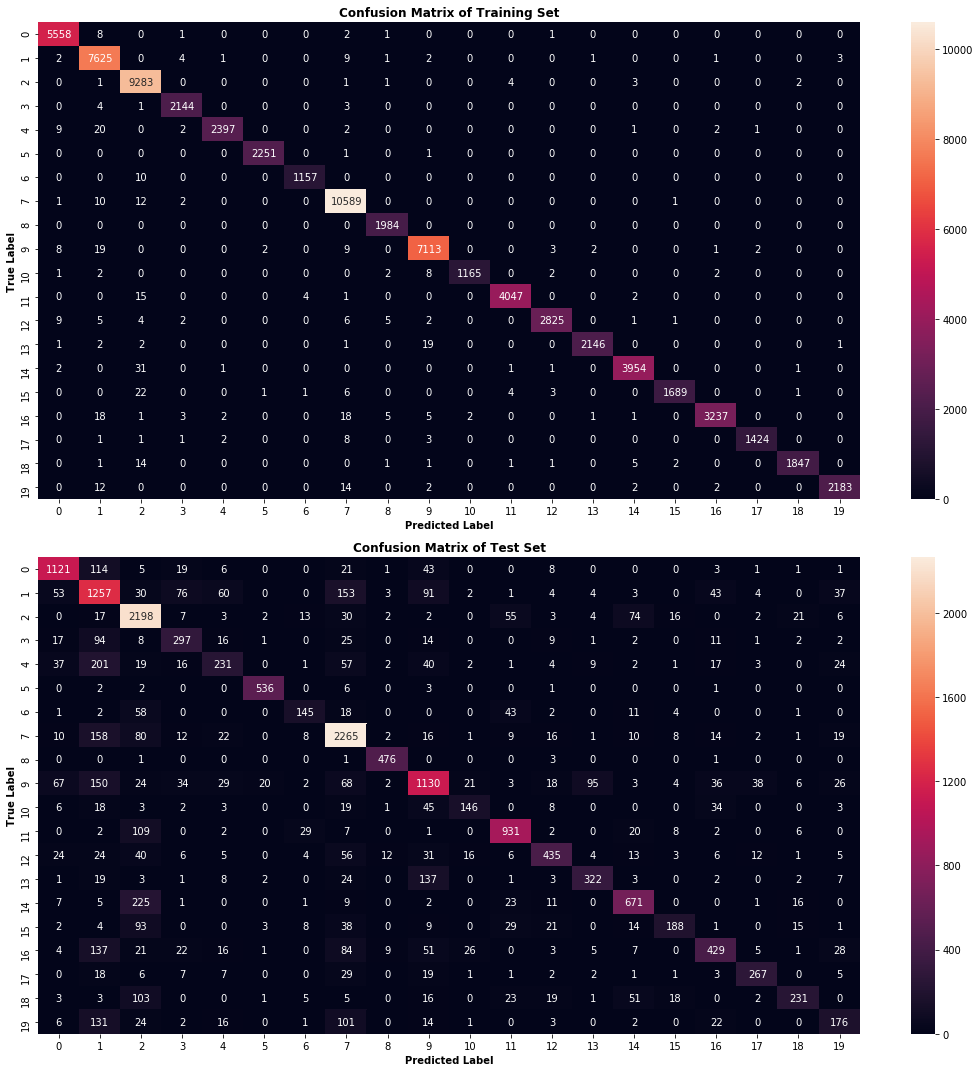

In [78]:
from sklearn.metrics import confusion_matrix

# create heatmap of confusion matrix
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(Y_train, pred_train), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(Y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

## Model 5: Oversampled Minority Varieties
As shown in the variety count below, Pinot Noir and Chardonnay are the majority group with 13k and 11k bottles respectively. The large number of samples of these two variety skews the accuracy of the minority group i.e. the bottles with fewer samples. For this model, all the varieties samples were oversampled to increase the samples of the Pinot Noir 13,269. This resulted in a significantly improved model. The training set scored a 99% in accuracy and the test set scored 96% in accuracy. By oversampling the minority groups, overfitment was reduced through the random forest to produce a near perfect performing model.  

In [79]:
var_df['variety'].value_counts()

Pinot Noir                  13269
Chardonnay                  11750
Cabernet Sauvignon           9470
Red Blend                    8935
Bordeaux-style Red Blend     6915
Riesling                     5188
Sauvignon Blanc              4963
Syrah                        4142
Rosé                         3563
Merlot                       3101
Nebbiolo                     2804
Zinfandel                    2714
Sangiovese                   2707
Malbec                       2652
Portuguese Red               2466
White Blend                  2354
Sparkling Blend              2153
Tempranillo                  1809
Rhône-style Red Blend        1470
Pinot Gris                   1452
Name: variety, dtype: int64

In [80]:
def oversample(variety_list):
    majority = var_df['variety'].value_counts().max()
    over_df = pd.DataFrame()
    
    for i, var in enumerate(variety_list):
        var = var_df[var_df['variety']==var]
        var = var.sample(majority, replace=True)
        over_df = pd.concat([over_df, var], axis=0)
        
    return over_df    
        
over_df = oversample(variety_largest)
over_df['variety'].value_counts()

Sauvignon Blanc             13269
Portuguese Red              13269
Rhône-style Red Blend       13269
Chardonnay                  13269
Rosé                        13269
Malbec                      13269
Syrah                       13269
Pinot Gris                  13269
Riesling                    13269
Tempranillo                 13269
Red Blend                   13269
Sangiovese                  13269
Bordeaux-style Red Blend    13269
White Blend                 13269
Zinfandel                   13269
Pinot Noir                  13269
Nebbiolo                    13269
Sparkling Blend             13269
Cabernet Sauvignon          13269
Merlot                      13269
Name: variety, dtype: int64

In [81]:
# Y is the target variable
Y = over_df['variety']

# X is the features
X = over_df.select_dtypes(exclude ='object') 

# Create trainging and test sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [82]:
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

# Fit train and test data
forest = forest.fit(X_train, Y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(forest, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(forest, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Cross Validation of Training Set:
[0.95460111 0.95478629 0.95530226 0.95555399 0.95357109]

Cross Validation of Test Set:
[0.82247741 0.812188   0.82279793 0.81294761 0.82145551]

Accuracy Score of Training Set: 0.999524267088703

Accuracy Score of Test Set: 0.968121184716256

--- 69.95595574378967 seconds ---


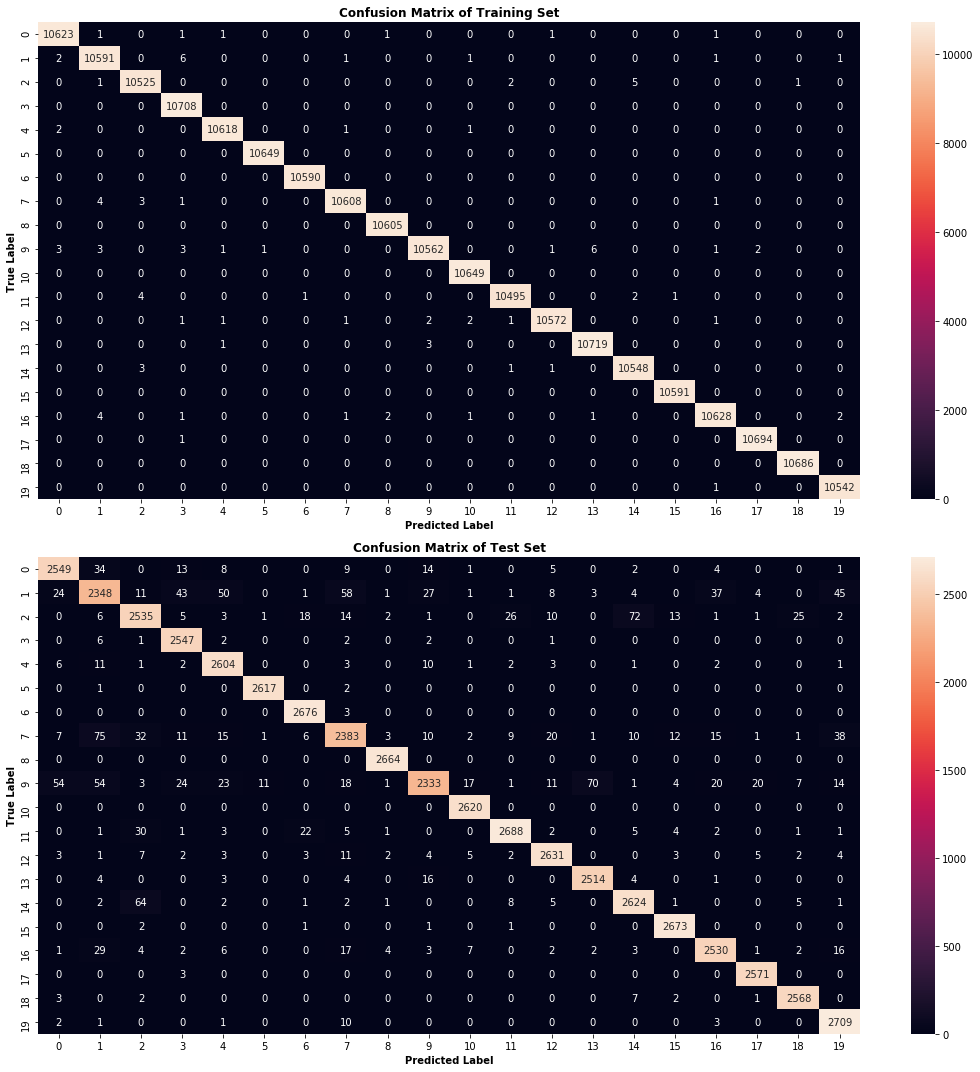

In [83]:
# create heatmap of confusion matrix
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(Y_train, pred_train), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(Y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

## Model 6: Hyperparameters
This model took model 5 one step further, using hyperparameter tuning to perfect the model. For all the random forest models above, the default parameters were used. See print out of default parameters below for reference. The parameters that were tuned were the n_estimators, the max_depth, min samples split, min samples leaf, and bootstrap. Since model 5 had extremely good results, the range for each of these parameters were kept relatively small. A list was randomly generated for n_estimators, min samples split, and max_depth. By randomly generating a list one isn't guaranteed to fit the best parameters, but some of the top performing parameters will be. This will greatly reduce the run time of the model with almost similar results.

A grid search was utilized to iterate through all the parameters chosen and the best parameters were returned. The best parameters were fitted to the random forest classifer, and the results will be analyzed in the 'Summary and Conclusion' section below. 

In [84]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(forest.get_params())

Parameters currently in use:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [85]:
from sklearn.model_selection import GridSearchCV
import random 
  
def Rand(start, end, num): 
    """ Return: List of random integers
    
    Parameters:
    start(int): Minimum list point
    end(int): Maximum list point
    num(int): Length of list"""
    
    res = [] 
    for j in range(num): 
        res.append(random.randint(start, end)) 
    return res 

# Number of trees in random forest
n_estimators = Rand(5, 50, 10)
n_estimators.append(10)

# Maximum number of levels in tree
max_depth = Rand(1, 10, 3)
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = Rand(1, 10, 3)

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [27, 48, 26, 47, 10, 22, 32, 35, 48, 9, 10], 'max_depth': [4, 1, 7, None], 'min_samples_split': [9, 7, 9], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


In [86]:
# Use the random grid to search for best hyperparameters
forest = RandomForestClassifier()

# Random search of parameters, using 2 fold cross validation, 
# Search across all combinations, and use all available cores
rf_random = GridSearchCV(estimator=forest, param_grid=random_grid, 
                         cv=2, verbose=2, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 1056 candidates, totalling 2112 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 2112 out of 2112 | elapsed: 75.0min finished


{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 48}


In [87]:
start_time = time.time()

# Fit best parameters to random forest
params = rf_random.best_params_
forest = RandomForestClassifier(**params)
forest = forest.fit(X_train, Y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

# Print results of test and train data
print('Cross Validation of Training Set:')
print(cross_val_score(forest, X_train, Y_train, cv=5))
print('\nCross Validation of Test Set:')
print(cross_val_score(forest, X_test, Y_test, cv=5))

print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Cross Validation of Training Set:
[0.96449091 0.96354645 0.96347408 0.96422178 0.96094413]

Cross Validation of Test Set:
[0.84920934 0.84741452 0.85105982 0.84809649 0.85520362]

Accuracy Score of Training Set: 0.9999057954631095

Accuracy Score of Test Set: 0.9743952068731631

--- 388.6461617946625 seconds ---


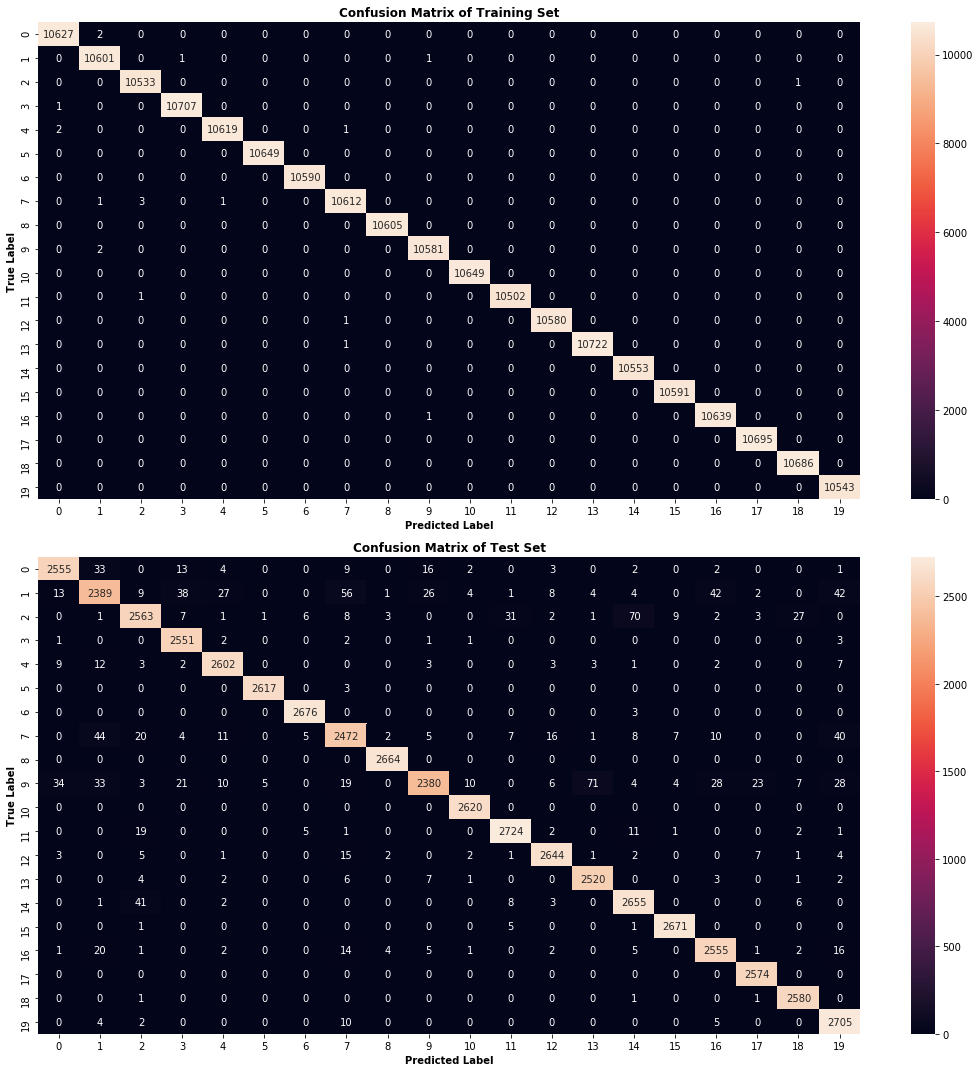

In [88]:
# create heatmap of confusion matrix
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(Y_train, pred_train), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(Y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary and Conclusion
In this project, over 130k bottles of wines were explored. The majority of the world's wines are produced in 3 countries the US, France, and Italy. While each country had individual specialties, it is noted that certain varieties were produced in all countries. The points and variety of a given bottle greatly affect the price of the bottle. 

Natural Language Processing was used to extract and weight all the keywords within each bottle's tasting notes. These keywords were used to create dummies for additional features in the model. This dataset was selected to create a model that could create a recommendation model for specific bottles of wine. During the data exploration, it was noted that each bottle was only represented in the dataset on average 1.08 times. This low average bottle count meant that there were not enough samples to model this recommendation accurately. Variety was chosen instead due to its larger sample size for modeling. 

In terms of the models produced, the best model was 'Model 6: Hyperparameters'. The training accuracy was 99.9% and the test accuracy was 97.7%. The confusion matrix shows the spread of the type I and type II errors, for model 6 the 2.3% of errors were evenly spread throughout the varieties. The main weak point of each of the models is that they only predict the variety of bottles of wine, which is a pretty broad classification as user tastes differ across varieties. For example, the age of a bottle or the region in which it was produced can change the vintage's flavor within a variety that one user prefers more than another. This recommendation model still has practical uses. However, users could use this model as a starting point of which variety of wine to explore. 

# References
Data - https://www.kaggle.com/zynicide/wine-reviews